# Install Dependencies

In [1]:
!pip install tensorflow==2.10.0

In [2]:
!pip install tensorflow-gpu==2.10.0

In [3]:
!pip install opencv-python

In [4]:
!pip install matplotlib

# Import Dependencies

In [5]:
#importing standard dependencies

import cv2
import os
import random
import time
import numpy as np
import requests
from matplotlib import pyplot as plt

In [6]:
#imporing tensorflow dependencies - Functional API

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf


# Set GPU Growth

#### This is to avoid the out of memory error and limit the GPU usage
#### If memory growth is enabled for a PhysicalDevice, the runtime initialization will not allocate all memory on the device.

In [7]:
#check the number of available GPU and also check if tensorflow is detecting it
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 0


In [8]:
#getting the details of the GPU
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16890474213856587283
 xla_global_id: -1]

In [9]:
#setting memory growth for GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

# Create folder structure

In [10]:
import tempfile

temp_dir = tempfile.gettempdir() # retrieves the system's temporary directory

temp_dir

'C:\\Users\\Utsav\\AppData\\Local\\Temp'

In [11]:
# Setup paths in temp dir
POS_PATH = os.path.join(temp_dir,'data', 'positive')
NEG_PATH = os.path.join(temp_dir,'data', 'negative')
ANC_PATH = os.path.join(temp_dir,'data', 'anchor')

print("Positive path: ",POS_PATH)
print("Negative path: ",NEG_PATH)
print("Anchor path: ",ANC_PATH)

Positive path:  C:\Users\Utsav\AppData\Local\Temp\data\positive
Negative path:  C:\Users\Utsav\AppData\Local\Temp\data\negative
Anchor path:  C:\Users\Utsav\AppData\Local\Temp\data\anchor


In [12]:

# Make the directories
if not os.path.exists(POS_PATH):
    os.makedirs(POS_PATH)
if not os.path.exists(NEG_PATH):
    os.makedirs(NEG_PATH)
if not os.path.exists(ANC_PATH):
    os.makedirs(ANC_PATH)

# Collect Positives,Negatives and Anchors

#### Negatives collection from existing dataset

In [28]:
from urllib import request

url = "https://figshare.com/ndownloader/files/5976018/lfw.tgz"
target_path = os.path.join(NEG_PATH,"lfw.tgz")

with request.urlopen(request.Request(url), timeout=15.0) as response:
    if response.status == 200:
        with open(target_path, "wb") as f:
            f.write(response.read())

In [29]:
import tarfile

def uncompress_tar(tar_filepath, extract_path):
    try:
        with tarfile.open(tar_filepath, 'r') as tar:
            tar.extractall(path=extract_path)
        print(f"Successfully extracted '{tar_filepath}' to '{extract_path}'")
    except FileNotFoundError:
        print(f"Error: Tar file '{tar_filepath}' not found.")
    except tarfile.ReadError as e:
         print(f"Error: Could not open '{tar_filepath}'. It may be corrupted or not a valid tar file. Details: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

In [30]:
uncompress_tar(target_path,NEG_PATH)

Successfully extracted 'C:\Users\Utsav\AppData\Local\Temp\data\negative\lfw.tgz' to 'C:\Users\Utsav\AppData\Local\Temp\data\negative'


In [31]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir(os.path.join(NEG_PATH,"lfw")):
    for file in os.listdir(os.path.join(os.path.join(NEG_PATH,"lfw"), directory)):
        EX_PATH = os.path.join(os.path.join(NEG_PATH,"lfw"), directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [32]:
import shutil
# removing the tar and extracted folder from NEG_PATh
os.remove(target_path)
shutil.rmtree(os.path.join(NEG_PATH,"lfw"))

#### Positive collection from webcam

In [17]:
# importing uuid library to geenrate unique image names
import uuid

In [35]:
cap = cv2.VideoCapture(0)

# Set the capture duration to 5 minutes (300 seconds)
capture_duration = 30

# Record start time
start_time = time.time()

while(int(time.time() - start_time) < capture_duration):
    ret, frame = cap.read()

    #to capture only 250x250px to make all images a standard size
    frame = frame[120:120+250,200:200+250,:]

    #to rectify the lateral inversion
    flipped_frame = cv2.flip(frame, 1)

    cv2.waitKey(1)

    # Create the unique file path 
    imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
    
    # Write out anchor image
    cv2.imwrite(imgname, frame)

    cv2.imshow('Image collection',flipped_frame)
   

cap.release()
cv2.destroyAllWindows()

#### Anchor collection from webcam

In [36]:
cap = cv2.VideoCapture(0)

# Set the capture duration to 5 minutes (300 seconds)
capture_duration = 30

# Record start time
start_time = time.time()

while(int(time.time() - start_time) < capture_duration):
    ret, frame = cap.read()

    #to capture only 250x250px to make all images a standard size
    frame = frame[120:120+250,200:200+250,:]

    #to rectify the lateral inversion
    flipped_frame = cv2.flip(frame, 1)

    cv2.waitKey(1)

    # Create the unique file path 
    imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
    
    # Write out anchor image
    cv2.imwrite(imgname, frame)

    cv2.imshow('Image collection',flipped_frame)
   

cap.release()
cv2.destroyAllWindows()

# Data Augmentation

In [37]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [38]:
for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [39]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# Load and Preprocess Images

#### Get images directories

In [40]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [41]:
dir_test = anchor.as_numpy_iterator()

In [42]:
#to check if the iterator is reading all the imaage path
print(dir_test.next())

b'C:\\Users\\Utsav\\AppData\\Local\\Temp\\data\\anchor\\0b32e25c-376e-11f0-abec-000d3af0c63d.jpg'


#### Preprocessing - Scale and Resize

In [43]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [44]:
img = preprocess(dir_test.next())

In [45]:
img.numpy()

array([[[0.7894608 , 0.84436274, 0.7855392 ],
        [0.7882353 , 0.84313726, 0.7862745 ],
        [0.79509807, 0.85      , 0.79901963],
        ...,
        [0.8029412 , 0.8303922 , 0.79901963],
        [0.79338235, 0.8208333 , 0.7894608 ],
        [0.7941176 , 0.8137255 , 0.7862745 ]],

       [[0.7830882 , 0.84093136, 0.78112745],
        [0.77916664, 0.83406866, 0.7752451 ],
        [0.78210783, 0.8370098 , 0.782598  ],
        ...,
        [0.7970588 , 0.8245098 , 0.79313725],
        [0.79093134, 0.8183824 , 0.7870098 ],
        [0.78431374, 0.80588233, 0.77843136]],

       [[0.7747549 , 0.83259803, 0.7727941 ],
        [0.7747549 , 0.82965684, 0.7708333 ],
        [0.78137255, 0.8362745 , 0.777451  ],
        ...,
        [0.7855392 , 0.8151961 , 0.7772059 ],
        [0.78039217, 0.80784315, 0.7764706 ],
        [0.777451  , 0.80490196, 0.777451  ]],

       ...,

       [[0.7443628 , 0.83455884, 0.79534316],
        [0.7490196 , 0.8392157 , 0.80196077],
        [0.7529412 , 0

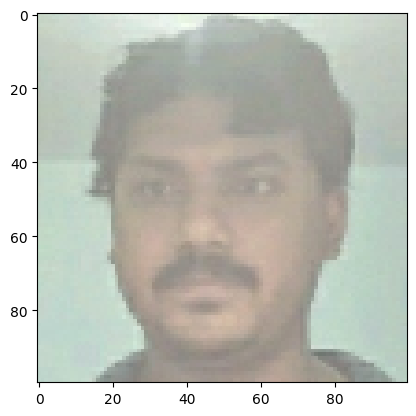

In [46]:
#to check the scaling is working. We will see the image size should be 100x100px
plt.imshow(img)

#### Create Labelled Dataset

In [47]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [48]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [49]:
samples = data.as_numpy_iterator()

In [50]:
example = samples.next()

In [51]:
example

(b'C:\\Users\\Utsav\\AppData\\Local\\Temp\\data\\anchor\\01e35ab0-376e-11f0-894c-000d3af0c63d.jpg',
 b'C:\\Users\\Utsav\\AppData\\Local\\Temp\\data\\positive\\22a3775e-376e-11f0-a1c0-000d3af0c63d.jpg',
 1.0)

#### Build Train and Test Partition

In [52]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [53]:
res = preprocess_twin(*example)

In [54]:
res

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.79534316, 0.82279414, 0.7914216 ],
         [0.7889706 , 0.81936276, 0.7870098 ],
         [0.79019606, 0.82941175, 0.7941176 ],
         ...,
         [0.8004902 , 0.80833334, 0.79068625],
         [0.7889706 , 0.7968137 , 0.79093134],
         [0.7862745 , 0.7941176 , 0.79019606]],
 
        [[0.782598  , 0.8129902 , 0.78161764],
         [0.7796569 , 0.8188726 , 0.78455883],
         [0.7828431 , 0.82279414, 0.7884804 ],
         ...,
         [0.79632354, 0.80269605, 0.7872549 ],
         [0.7887255 , 0.79656863, 0.7892157 ],
         [0.7735294 , 0.7892157 , 0.7852941 ]],
 
        [[0.76960784, 0.8088235 , 0.777451  ],
         [0.77009803, 0.8122549 , 0.78088236],
         [0.7769608 , 0.81985295, 0.7884804 ],
         ...,
         [0.7870098 , 0.7889706 , 0.7801471 ],
         [0.775     , 0.7894608 , 0.7754902 ],
         [0.76960784, 0.7882353 , 0.7754902 ]],
 
        ...,
 
        [[0.75686276, 0.81960785

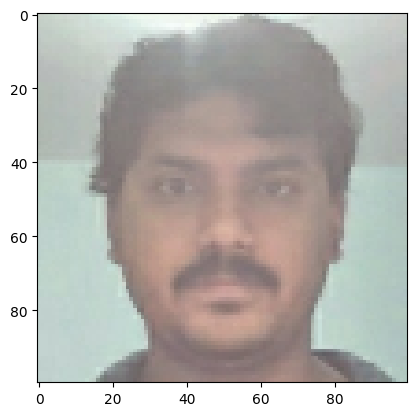

In [55]:
plt.imshow(res[0])

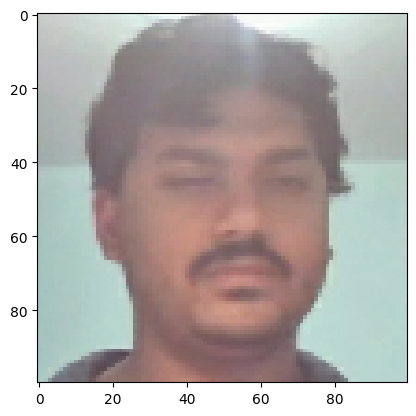

In [56]:
plt.imshow(res[1])

In [57]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [58]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [59]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Model Engineering

#### Build Embedding Layer

In [60]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [61]:
embedding = make_embedding()

In [62]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

#### Build Distance Layer

In [63]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [64]:
l1 = L1Dist()

In [65]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined